In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import scipy.io as sio
import anndata as ad
import seaborn as sns
import os as os
import sys as sys
sys.path.append('/home/qiuaodon/Desktop/PanCancer_scRNA_analysis/utils/')
from scRNA_utils import *
import operator as op
import matplotlib.colors as mcolors

# load in sc data

In [2]:
data_dir_NHDP = "/home/qiuaodon/Desktop/project_data_new/"
adata_T = sc.read(data_dir_NHDP + '1863-counts_cells_cohort1_T_cells.h5ad')
adata_1 = adata_T[adata_T[:,'PDCD1'].X > 0, :]
adata_M = sc.read(data_dir_NHDP + '1863-counts_cells_cohort1_M_cells.h5ad')
adata_2 = adata_M

In [3]:
adata_1_pseudo = scRNA2PseudoBulkAnnData(adata_1, sample_id_col='sample_id')
adata_2_pseudo = scRNA2PseudoBulkAnnData(adata_2, sample_id_col='sample_id')

/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


# prepare data matrix for IVtest

In [4]:
DEG_1 = paird_ttest(adata_1, condition_key = 'timepoint', sample_id_col = 'sample_id', patient_id_col = 'patient_id')
DEG_2 = paird_ttest(adata_2, condition_key = 'timepoint', sample_id_col = 'sample_id', patient_id_col = 'patient_id')

Input adata is not pseudo-bulk RNA data. Convert to pseudo-bulk RNA data.


/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Input adata is not pseudo-bulk RNA data. Convert to pseudo-bulk RNA data.


/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
DEG_1 = DEG_1[DEG_1['pval'] < 0.05]
DEG_2 = DEG_2[DEG_2['pval'] < 0.05]
gene_1 = DEG_1.index.tolist()
gene_2 = DEG_2.index.tolist()

# Filter out invalid gene names
gene_1 = [gene for gene in gene_1 if gene in adata_1_pseudo.var_names]
gene_2 = [gene for gene in gene_2 if gene in adata_2_pseudo.var_names]

gene_1_matrix = adata_1_pseudo[:, gene_1].X
gene_2_matrix = adata_2_pseudo[:, gene_2].X
gene_1_df = pd.DataFrame(gene_1_matrix, columns=gene_1, index=adata_1_pseudo.obs['sample_id'])
gene_2_df = pd.DataFrame(gene_2_matrix, columns=gene_2, index=adata_2_pseudo.obs['sample_id'])
gene_1_df.columns = [i + '_T' for i in gene_1_df.columns]
gene_2_df.columns = [i + '_M' for i in gene_2_df.columns]
gene_df = gene_1_df
gene_df = pd.merge(gene_df, gene_2_df, on='sample_id')

In [6]:
gene_df['treatment'] = gene_df.index.str.contains('On').astype(int)
# get patient id from sample id remove the _On or _Pre
gene_df['patient_id'] = gene_df.index.str.replace('_On', '').str.replace('_Pre', '')
gene_df['treatment'].value_counts()

0    31
1    31
Name: treatment, dtype: int64

# group the DEG pairs together using L and R

In [10]:
results = pd.read_excel('/home/qiuaodon/Desktop/project_data_new/CIT_results_PD1vsMyeloid_fisherz_corr03.xlsx')

In [11]:
# results = pd.read_excel('/home/qiuaodon/Desktop/project_data_new/CIT_results_TvsM_fisherz_corrmorethan0.3.xlsx')
# results = results.drop(columns=['Unnamed: 0'])
# # Remove the suffix '_X' from g1 and g2
results['g1'] = results['g1'].str.replace(r'_\w+', '', regex=True)
results['g2'] = results['g2'].str.replace(r'_\w+', '', regex=True)
results

,Unnamed: 0,g1,g2,L,R,pValue,g1vsg2_correlation,g1_residualvsg2_residuals_correlation
0,0,CXCR4,CXCR4,ANXA1,CXCR4,0.209906,0.619111,0.163164
1,1,AREG,TNFAIP3,AREG,ICAM1,0.786265,0.605187,-0.035590
2,2,ZFP36,RHOB,RPS19,C5AR1,0.119450,0.538987,0.201654
3,3,IL7R,HERPUD1,ANXA1,CXCR4,0.068493,0.535807,0.234747
4,4,CXCR4,ETS2,ANXA1,CXCR4,0.205761,0.526175,0.164631
...,...,...,...,...,...,...,...,...
3522,3522,IL2RB,PKP2,ANXA1,CXCR4,0.104500,-0.449056,-0.209994
3523,3523,IL2RB,PKP2,ITGA4,CXCR4,0.064306,-0.449056,-0.238255
3524,3524,IRF1,CXCR4,CCL5,CXCR4,0.054402,-0.466274,-0.247346
3525,3525,HMGB2,TENT5A,HMGB2,DAB2,0.453657,-0.473293,-0.098076


In [9]:
results = results[results['pValue'] > 0.1]

In [14]:
# only keep the significant results with correlation > 0.3 or < -0.3
results = results[(results['g1vsg2_correlation'] < -0.3)]

In [15]:
calculate_g1_L_correlation(results, adata_1_pseudo)
calculate_g2_R_correlation(results, adata_2_pseudo)

,Unnamed: 0,g1,g2,L,R,pValue,g1vsg2_correlation,g1_residualvsg2_residuals_correlation,g1vsL_correlation,g2vsR_correlation
2053,2053,TAGAP,SLC5A3,ANXA1,FPR1,0.053626,-0.300376,-0.248113,0.272354,-0.160565
2054,2054,TAGAP,SLC5A3,RPS19,C5AR1,0.056661,-0.300376,-0.245162,0.216502,-0.229962
2055,2055,TAGAP,SLC5A3,ICAM1,ITGAX,0.083919,-0.300376,-0.223131,-0.482641,-0.063959
2056,2056,TAGAP,SLC5A3,CSF2,SDC2,0.085627,-0.300376,-0.221951,-0.363069,0.096445
2057,2057,TAGAP,SLC5A3,CALR,LRP5,0.051208,-0.300376,-0.250562,0.113120,-0.214389
...,...,...,...,...,...,...,...,...,...,...
3522,3522,IL2RB,PKP2,ANXA1,CXCR4,0.104500,-0.449056,-0.209994,-0.253159,0.588634
3523,3523,IL2RB,PKP2,ITGA4,CXCR4,0.064306,-0.449056,-0.238255,-0.164924,0.588634
3524,3524,IRF1,CXCR4,CCL5,CXCR4,0.054402,-0.466274,-0.247346,-0.114238,1.000000
3525,3525,HMGB2,TENT5A,HMGB2,DAB2,0.453657,-0.473293,-0.098076,1.000000,-0.351516


In [16]:
# remove the rows with g1vsL_correlation < 0.3 
results = results[(abs(results['g1vsL_correlation']) > 0.3) & (results['g1vsL_correlation'] < 0.99)]
# remove the rows with g2vsR_correlation < 0.3 
results = results[(abs(results['g2vsR_correlation']) > 0.3) & (results['g2vsR_correlation'] < 0.99)]

In [17]:
results

,Unnamed: 0,g1,g2,L,R,pValue,g1vsg2_correlation,g1_residualvsg2_residuals_correlation,g1vsL_correlation,g2vsR_correlation
2069,2069,TAGAP,SLC5A3,CXCL13,HCAR3,0.175485,-0.300376,-0.176039,-0.314635,0.300989
2070,2070,TAGAP,SLC5A3,CXCL13,HCAR2,0.221510,-0.300376,-0.159160,-0.314635,0.413445
2084,2084,FKBP5,ANKAR,ITGA4,TFRC,0.122070,-0.300444,-0.200275,0.415490,-0.343374
2097,2097,SLA,IER2,XCL1,XCR1,0.083578,-0.300573,-0.223368,-0.350066,-0.329921
2110,2110,SLA,IER2,CXCL11,CCR7,0.084604,-0.300573,-0.222655,0.320832,-0.334492
...,...,...,...,...,...,...,...,...,...,...
3511,3511,TXNIP,TENT5A,HMGB2,DAB2,0.087406,-0.418909,-0.220741,0.333701,-0.351516
3517,3517,IRF1,RHOB,ICAM1,IL2RG,0.061802,-0.432292,-0.240441,0.554250,-0.565634
3518,3518,FKBP5,TENT5A,HMGB2,DAB2,0.135293,-0.436205,-0.193637,0.576387,-0.351516
3520,3520,PRDM1,TENT5A,HMGB2,DAB2,0.056949,-0.446106,-0.244889,0.597991,-0.351516


In [18]:
# get the unique (L,R) pairs in results
lr_pairs = results[['L', 'R']]
# remove the LR pairs repeated less than 3 times in the lr_pairs
lr_pairs = lr_pairs.groupby(['L', 'R']).filter(lambda x: len(x) >= 3)
lr_pairs = lr_pairs.drop_duplicates()
lr_pairs

,L,R
2069,CXCL13,HCAR3
2070,CXCL13,HCAR2
2084,ITGA4,TFRC
2116,CXCL13,CCR7
2226,CSF2,IL5RA
2231,ICAM1,IL2RG
2234,HMGB2,DAB2
2388,CXCL13,CXCR4
2411,CXCL13,FPR2
2415,CXCL13,P2RY14


In [19]:
import pandas as pd
grouped_results = results.groupby(["L", "R"])

# Display grouped data
grouped_dict = { (ligand, receptor): group for (ligand, receptor), group in grouped_results }

# Create a new DataFrame to hold the GEM1 and GEM2 groupings
grouped_data = []
tracked_gem1 = set()
tracked_gem2 = set()

min_gene_num = 2

# Temporary list to hold data before creating DataFrame
temp_data = []

for (ligand, receptor), group in grouped_results:
    gem1 = group["g1"].drop_duplicates().tolist()
    gem2 = group["g2"].drop_duplicates().tolist()
    
    # Check the overlap between current GEM_g1 and previously tracked GEM_g1
    overlap_gem1 = len(set(gem1) & tracked_gem1)
    overlap_gem2 = len(set(gem2) & tracked_gem2)
    
    # Filter to include only those with at least three genes in GEM_g1 and GEM_g2
    # and where the overlap is below the maximum allowable threshold
    if len(gem1) > min_gene_num and len(gem2) > min_gene_num:
        temp_data.append({
            "L": ligand,
            "R": receptor,
            "g1": gem1,
            "g2": gem2,
            "Num_genes_g1": len(gem1),
            "Num_genes_g2": len(gem2)
        })
        # Update the tracked GEM_g1 and GEM_g2 sets
        tracked_gem1.update(gem1)
        tracked_gem2.update(gem2)

# Convert the temporary data to a DataFrame
grouped_df = pd.DataFrame(temp_data)

# Function to find overlapping rows
def find_overlapping_rows(df, column_name):
    overlap_info = []
    for index, row in df.iterrows():
        current_set = set(row[column_name])
        overlapping_rows = []
        for other_index, other_row in df.iterrows():
            if index != other_index:
                other_set = set(other_row[column_name])
                overlap = len(current_set & other_set)
                if overlap > len(current_set) / 3: # Set the threshold for overlap
                    overlapping_rows.append(other_index)
        overlap_info.append(overlapping_rows)
    return overlap_info

# Add columns for overlapping rows in GEM_g1 and GEM_g2
grouped_df["Overlapping_g1"] = find_overlapping_rows(grouped_df, "g1")
grouped_df["Overlapping_g2"] = find_overlapping_rows(grouped_df, "g2")


In [20]:
# rank each GEM_g1 by order of name inside
grouped_df['g1'] = grouped_df['g1'].apply(lambda x: sorted(x))
grouped_df['g2'] = grouped_df['g2'].apply(lambda x: sorted(x))
grouped_df

,L,R,g1,g2,Num_genes_g1,Num_genes_g2,Overlapping_g1,Overlapping_g2
0,ANXA1,CCR2,"[ANKRD28, BCL2L11, SLA, TNFSF14]","[BTG2, RAB11FIP1, RRP12, TSC22D1, TSPYL4, TUBA1A]",4,6,[],[]
1,CCL5,P2RY12,"[FASLG, NEAT1, PELI1]","[ACSM3, ELL2, PFKFB3, PPP1R13L]",3,4,[2],"[2, 10]"
2,CCL5,P2RY13,"[DDIT4, FASLG, NEAT1]","[ACSM3, BTG2, DUSP6, ELL2, PFKFB3]",3,5,[1],"[1, 10]"
3,CXCL13,CCR7,"[CTLA4, SLA, SLC2A3]","[DUSP6, IER2, SOCS1]",3,3,"[4, 7]",[]
4,CXCL13,CXCR4,"[CTLA4, PELI1, SLC2A3]","[DUSP6, RNF144B, UNC119B]",3,3,[3],[]
5,CXCL13,HCAR2,"[FASLG, TAGAP, TXNIP, ZFP36, ZFP36L2]","[CD2, HCAR3, HIST1H4H, NABP1, SESN1, SLC5A3]",5,6,"[6, 8, 10]","[6, 10]"
6,CXCL13,HCAR3,"[FASLG, TAGAP, ZFP36]","[CD2, SESN1, SLC5A3]",3,3,"[5, 8, 10]","[5, 10]"
7,CXCL13,P2RY14,"[SLA, SLC2A3, TUBA1A]","[PLAU, SMIM3, SOCS1]",3,3,[3],[]
8,HMGB2,DAB2,"[CEMIP2, CRYBG1, FASLG, FKBP5, IL2RB, KLF10, P...","[ARRDC3, CD163, CD2, CXCR4, ELL2, METTL21A, PD...",17,12,[],[10]
9,ICAM1,IL2RG,"[FASLG, GADD45B, IL2RB, IRF1, KLF10, RGS16, TN...","[ARRDC3, CD163, RHOB, SLC1A3]",8,4,[8],"[8, 10]"


In [21]:
#calculate the correlation between g1 and g2
calculate_GEM_correlation(grouped_df, adata_1_pseudo, adata_2_pseudo)
#calculate the residuals correlation between g1, g2 and LR
calculate_residuals_GEM_correlation(grouped_df, adata_1_pseudo, adata_2_pseudo)

,L,R,g1,g2,Num_genes_g1,Num_genes_g2,Overlapping_g1,Overlapping_g2,g1vsg2_correlation,g1_residualvsg2_residuals_correlation
0,ANXA1,CCR2,"[ANKRD28, BCL2L11, SLA, TNFSF14]","[BTG2, RAB11FIP1, RRP12, TSC22D1, TSPYL4, TUBA1A]",4,6,[],[],-0.337053,-0.177728
1,CCL5,P2RY12,"[FASLG, NEAT1, PELI1]","[ACSM3, ELL2, PFKFB3, PPP1R13L]",3,4,[2],"[2, 10]",0.175081,0.151657
2,CCL5,P2RY13,"[DDIT4, FASLG, NEAT1]","[ACSM3, BTG2, DUSP6, ELL2, PFKFB3]",3,5,[1],"[1, 10]",-0.337655,-0.200168
3,CXCL13,CCR7,"[CTLA4, SLA, SLC2A3]","[DUSP6, IER2, SOCS1]",3,3,"[4, 7]",[],-0.064544,-0.060363
4,CXCL13,CXCR4,"[CTLA4, PELI1, SLC2A3]","[DUSP6, RNF144B, UNC119B]",3,3,[3],[],-0.256244,-0.231251
5,CXCL13,HCAR2,"[FASLG, TAGAP, TXNIP, ZFP36, ZFP36L2]","[CD2, HCAR3, HIST1H4H, NABP1, SESN1, SLC5A3]",5,6,"[6, 8, 10]","[6, 10]",-0.022456,0.113286
6,CXCL13,HCAR3,"[FASLG, TAGAP, ZFP36]","[CD2, SESN1, SLC5A3]",3,3,"[5, 8, 10]","[5, 10]",0.290018,0.243506
7,CXCL13,P2RY14,"[SLA, SLC2A3, TUBA1A]","[PLAU, SMIM3, SOCS1]",3,3,[3],[],-0.051592,0.096452
8,HMGB2,DAB2,"[CEMIP2, CRYBG1, FASLG, FKBP5, IL2RB, KLF10, P...","[ARRDC3, CD163, CD2, CXCR4, ELL2, METTL21A, PD...",17,12,[],[10],0.681368,0.522898
9,ICAM1,IL2RG,"[FASLG, GADD45B, IL2RB, IRF1, KLF10, RGS16, TN...","[ARRDC3, CD163, RHOB, SLC1A3]",8,4,[8],"[8, 10]",-0.579623,-0.395202


In [22]:
grouped_df = grouped_df[grouped_df['g1vsg2_correlation'] < -0.3]
grouped_df 

,L,R,g1,g2,Num_genes_g1,Num_genes_g2,Overlapping_g1,Overlapping_g2,g1vsg2_correlation,g1_residualvsg2_residuals_correlation
0,ANXA1,CCR2,"[ANKRD28, BCL2L11, SLA, TNFSF14]","[BTG2, RAB11FIP1, RRP12, TSC22D1, TSPYL4, TUBA1A]",4,6,[],[],-0.337053,-0.177728
2,CCL5,P2RY13,"[DDIT4, FASLG, NEAT1]","[ACSM3, BTG2, DUSP6, ELL2, PFKFB3]",3,5,[1],"[1, 10]",-0.337655,-0.200168
9,ICAM1,IL2RG,"[FASLG, GADD45B, IL2RB, IRF1, KLF10, RGS16, TN...","[ARRDC3, CD163, RHOB, SLC1A3]",8,4,[8],"[8, 10]",-0.579623,-0.395202


# GEM plot and scatter plot

In [28]:
grouped_df['GEM_1'] = 'GEM_' + grouped_df.index.astype(str) + '_T'
grouped_df['GEM_2'] = 'GEM_' + grouped_df.index.astype(str) + '_M'

/tmp/ipykernel_1602857/1932422812.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df['GEM_1'] = 'GEM_' + grouped_df.index.astype(str) + '_T'
/tmp/ipykernel_1602857/1932422812.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df['GEM_2'] = 'GEM_' + grouped_df.index.astype(str) + '_M'


In [29]:
# Define a function to append '_T' to each gene name
def append_suffix(gene_list, suffix='_T'):
    # Ensure it's a list and not NaN or another unexpected type
    if isinstance(gene_list, list):
        return [gene + suffix for gene in gene_list]
    else:
        print("Unexpected format:", gene_list)
        return gene_list

# Apply the function to the GEM_g1 column to add '_T' to each gene name
DEG_pairs_T = grouped_df.copy()
DEG_pairs_T['g1'] = grouped_df['g1'].apply(lambda x: append_suffix(x, '_T'))

# Similarly for GEM_g2 if needed
DEG_pairs_T['g2'] = grouped_df['g2'].apply(lambda x: append_suffix(x, '_M'))
# remove the genes not in gene_df from each row in DEG_pairs_T but keep the row
DEG_pairs_T['g1'] = DEG_pairs_T['g1'].apply(lambda x: [gene for gene in x if gene in gene_df.columns])
DEG_pairs_T['g2'] = DEG_pairs_T['g2'].apply(lambda x: [gene for gene in x if gene in gene_df.columns])


# add GEM_1_T, GEM_2_T and so on to gene_df
for i, row in DEG_pairs_T.iterrows():
    GEM_1 = DEG_pairs_T.loc[i, 'g1']
    GEM_2 = DEG_pairs_T.loc[i, 'g2']
    gene_df['GEM_' + str(i) + '_T'] = gene_df[GEM_1].mean(axis=1)
    gene_df['GEM_' + str(i) + '_M'] = gene_df[GEM_2].mean(axis=1)
gene_df

,AC004687.1_T,AC004817.3_T,AC004951.1_T,AC006369.1_T,AC007038.2_T,AC015813.1_T,AC016831.5_T,AC021188.1_T,AC023157.3_T,AC025164.1_T,...,FFAR3_M,MAPT-AS1_M,treatment,patient_id,GEM_0_T,GEM_0_M,GEM_2_T,GEM_2_M,GEM_9_T,GEM_9_M
sample_id,,,,,,,,,,,,,,,,,,,,,
BIOKEY_13_Pre,496.245117,71.430817,0.000000,221.554840,0.000000,0.000000,0.000000,50.375000,66.970314,190.125916,...,0.000000,0.0,0,BIOKEY_13,605.320740,1119.071899,1570.965942,916.164673,1055.376587,876.710693
BIOKEY_13_On,548.931458,73.001106,105.453827,215.637390,50.366783,29.903372,0.000000,249.275970,106.639206,474.283173,...,0.000000,0.0,1,BIOKEY_13,1038.900146,565.751648,2389.239746,833.823425,812.771057,1265.396240
BIOKEY_10_Pre,563.980347,44.845234,55.078514,81.338425,5.761608,25.467459,9.838195,82.176804,36.126411,164.164597,...,0.000000,0.0,0,BIOKEY_10,706.709961,832.649597,1788.059570,816.749390,1308.485962,974.986328
BIOKEY_10_On,309.215912,189.972443,46.985409,88.311661,13.239152,40.373478,43.434666,111.079369,77.687202,379.605682,...,35.406757,0.0,1,BIOKEY_10,1034.777588,775.450867,2166.906982,913.888000,769.661255,1344.486572
BIOKEY_16_Pre,484.466187,89.122238,27.256454,405.647430,4.384324,32.537617,47.155140,20.080681,12.754025,204.002930,...,0.000000,0.0,0,BIOKEY_16,730.131287,800.903015,1965.215820,1110.474854,942.075684,1451.100708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BIOKEY_17_On,348.290375,523.852295,0.000000,0.000000,88.987106,0.000000,0.000000,165.759293,252.315216,456.512634,...,0.000000,0.0,1,BIOKEY_17,712.084351,854.442627,1624.510132,1097.479126,620.447998,2077.066162
BIOKEY_27_Pre,724.247070,0.000000,0.000000,234.127594,0.000000,0.000000,60.133003,0.000000,0.000000,68.258476,...,0.000000,0.0,0,BIOKEY_27,630.554077,1343.529907,1251.400513,1160.267700,965.516968,945.447632
BIOKEY_27_On,54.874050,330.519226,53.683594,225.546738,0.000000,58.787476,182.094040,169.446136,245.524399,598.750000,...,0.000000,0.0,1,BIOKEY_27,634.646423,954.862610,1945.038696,1107.253906,374.502777,2005.449341


In [30]:
# add GEM_1_T, GEM_2_T and so on to adata
DEG_pairs = grouped_df
for i, row in DEG_pairs.iterrows():
    GEM_1 = DEG_pairs.loc[i, 'g1']
    GEM_2 = DEG_pairs.loc[i, 'g2']
    # add GEMs to adata_1_pseudo and adata_2_pseudo
    adata_1_pseudo.obs['GEM_' + str(i) + '_T'] = adata_1_pseudo[:, GEM_1].X.mean(axis=1)
    adata_2_pseudo.obs['GEM_' + str(i) + '_M'] = adata_2_pseudo[:, GEM_2].X.mean(axis=1)
    # add GEMs to adata_1 and adata_2
    adata_1.obs['GEM_' + str(i) + '_T'] = adata_1[:, GEM_1].X.mean(axis=1)
    adata_2.obs['GEM_' + str(i) + '_M'] = adata_2[:, GEM_2].X.mean(axis=1)

In [31]:
CIT_GEM_test(grouped_df, adata_1_pseudo, adata_2_pseudo, gene_df, method="fisherz")

/home/qiuaodon/Desktop/PanCancer_scRNA_analysis/utils/scRNA_utils.py:1650: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df['pValue'] = np.nan


,L,R,g1,g2,Num_genes_g1,Num_genes_g2,Overlapping_g1,Overlapping_g2,g1vsg2_correlation,g1_residualvsg2_residuals_correlation,pValue,GEM_1,GEM_2
0,ANXA1,CCR2,"[ANKRD28, BCL2L11, SLA, TNFSF14]","[BTG2, RAB11FIP1, RRP12, TSC22D1, TSPYL4, TUBA1A]",4,6,[],[],-0.337053,-0.177728,0.171292,GEM_0_T,GEM_0_M
2,CCL5,P2RY13,"[DDIT4, FASLG, NEAT1]","[ACSM3, BTG2, DUSP6, ELL2, PFKFB3]",3,5,[1],"[1, 10]",-0.337655,-0.200168,0.122275,GEM_2_T,GEM_2_M
9,ICAM1,IL2RG,"[FASLG, GADD45B, IL2RB, IRF1, KLF10, RGS16, TN...","[ARRDC3, CD163, RHOB, SLC1A3]",8,4,[8],"[8, 10]",-0.579623,-0.395202,0.001458,GEM_9_T,GEM_9_M


In [32]:
# save the grouped_df to excel
grouped_df.to_excel('/home/qiuaodon/Desktop/project_data_new/CIT_results_PD1vsM_grouped_0920_negative.xlsx')

In [21]:
# cmap from grey to blue for UMAP
cmap = mcolors.LinearSegmentedColormap.from_list("", ["grey","blue"])


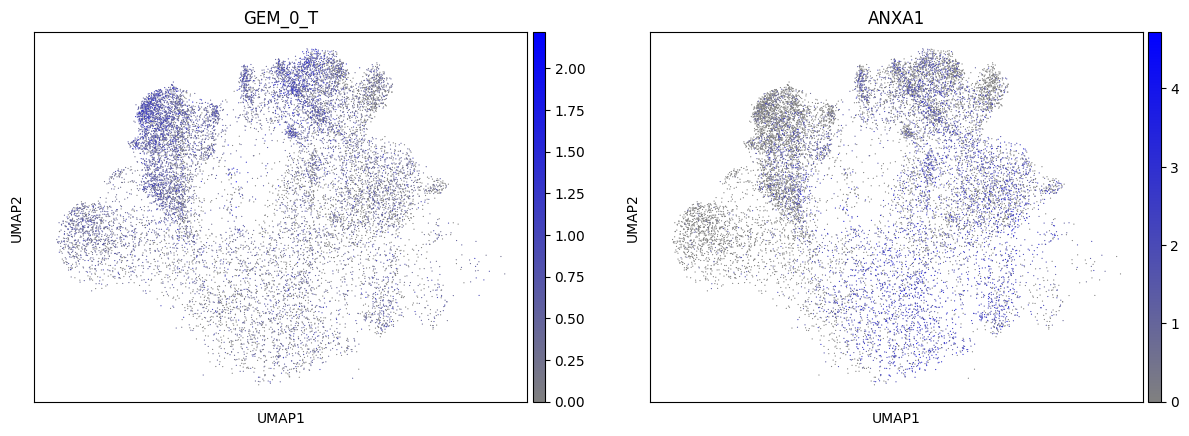

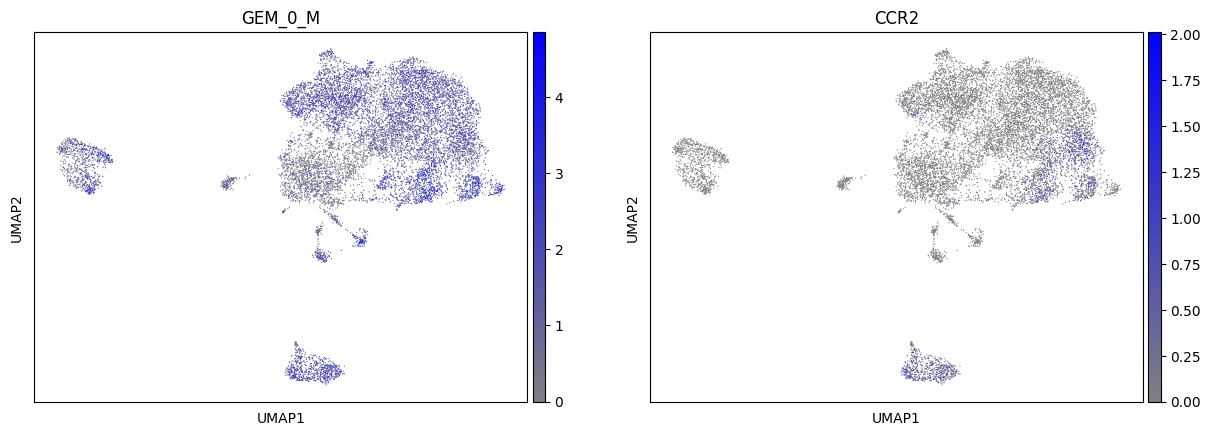

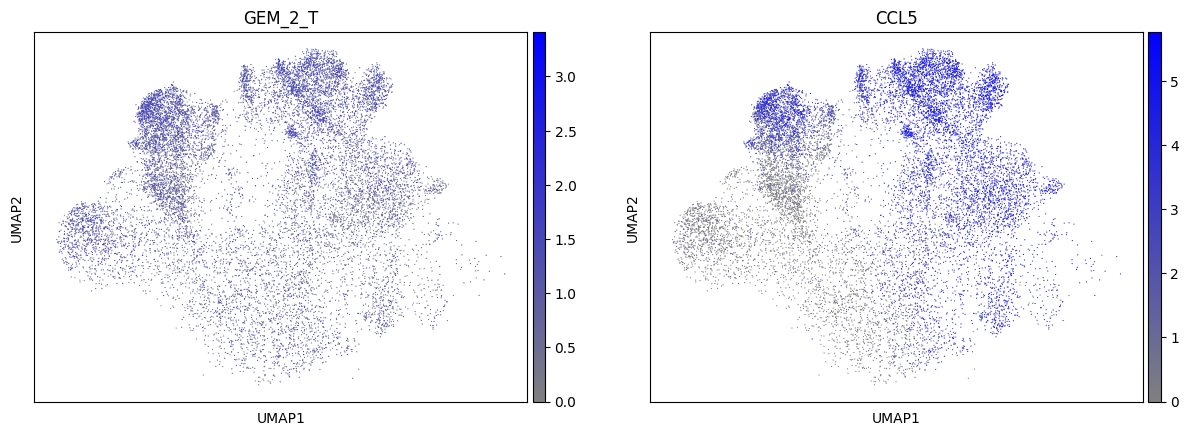

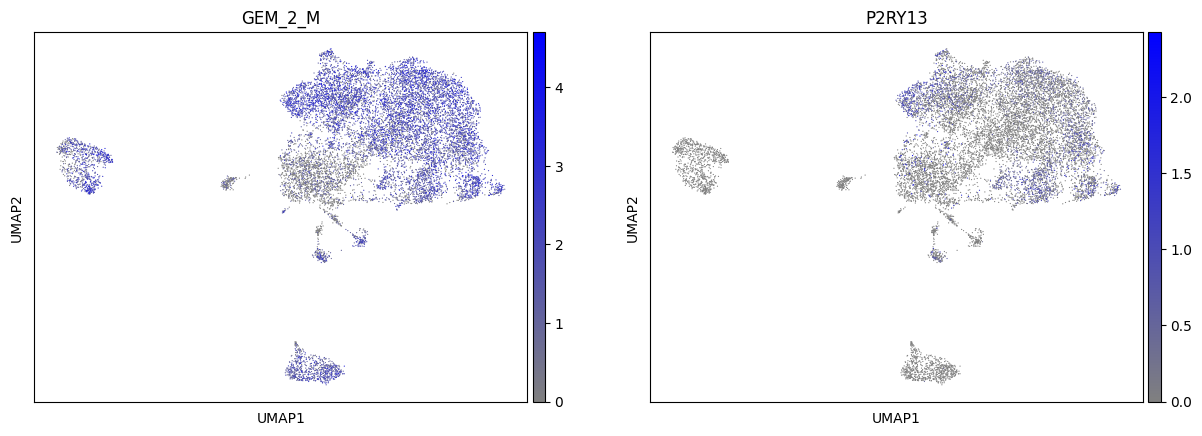

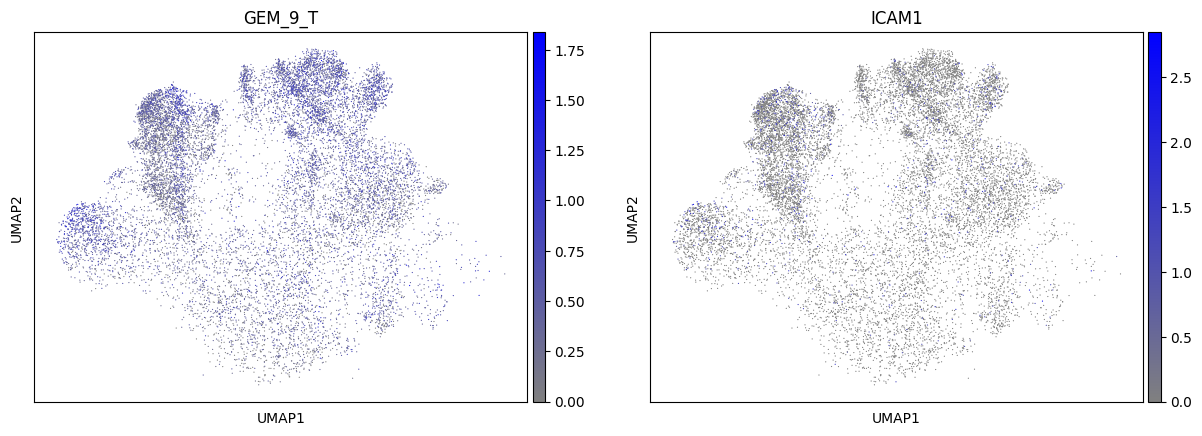

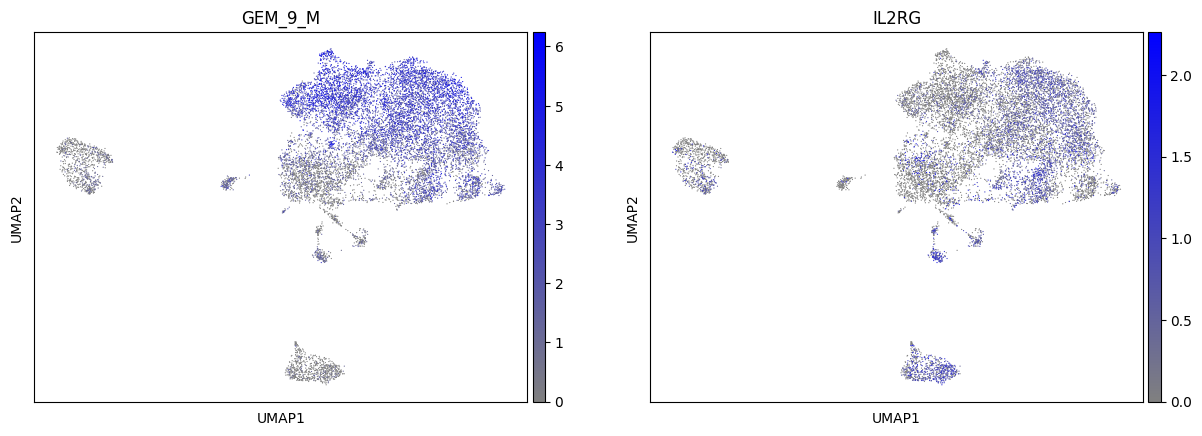

In [22]:
# plot the UMAP of GEMs
for i, row in DEG_pairs_T.iterrows():
    GEM_1 = DEG_pairs.loc[i, 'g1']
    GEM_2 = DEG_pairs.loc[i, 'g2']
    L = DEG_pairs.loc[i, 'L']
    R = DEG_pairs.loc[i, 'R']
    sc.pl.umap(adata_1, color=['GEM_' + str(i) + '_T', L], title='GEM_' + str(i) + '_T', cmap=cmap, size = 3)
    sc.pl.umap(adata_2, color=['GEM_' + str(i) + '_M', R], title='GEM_' + str(i) + '_M', cmap=cmap, size = 3)

In [55]:
def plot_CIT_GEM_DEGcorr(g1, g2, L, R, DEG_exp, pseudo_1, pseudo_2):
    # Define a custom palette
    palette = {'pre': "#E69F00", 'on': "#56B4E9"}
    #replace the treatment column 0 pre and 1 on
    DEG_exp['treatment'] = DEG_exp['treatment'].replace({0: 'pre', 1: 'on'})
    # Set font sizes
    title_fontsize = 14
    axis_fontsize = 14
    legend_fontsize = 12

    def adjust_plot_limits(ax, x_data, y_data):
        x_min, x_max = x_data.min(), x_data.max()
        y_min, y_max = y_data.min(), y_data.max()
        x_padding = (x_max - x_min) * 0.1
        y_padding = (y_max - y_min) * 0.1
        ax.set_xlim(x_min - x_padding, x_max + x_padding)
        ax.set_ylim(y_min - y_padding, y_max + y_padding)

    # Plot the jointplot between DEG of g1 and g2
    g1_exp = DEG_exp[g1]
    g2_exp = DEG_exp[g2]
    df1 = pd.DataFrame({g1: g1_exp, g2: g2_exp, 'treatment': DEG_exp['treatment']})
    df1 = df1.dropna()
    g = sns.jointplot(x=g1, y=g2, data=df1, hue='treatment', palette=palette, kind='scatter', marginal_kws=dict(fill=True))
    sns.regplot(x=g1, y=g2, data=df1, scatter=False, ax=g.ax_joint, color='black')
    adjust_plot_limits(g.ax_joint, df1[g1], df1[g2])
    
    g.ax_joint.tick_params(left=False, bottom=False)
    g.ax_marg_x.tick_params(bottom=False)
    g.ax_marg_y.tick_params(left=False)
    cor = pearsonr(df1[g1], df1[g2])[0]
    plt.suptitle(f'Correlation between {g1} and {g2} is {cor:.3f}', fontsize=title_fontsize)
    plt.subplots_adjust(top=0.95)
    plt.show()

     # Plot the jointplot between DEG of g1 and g2 residue
    L_values = pseudo_1[:, L].X.toarray().flatten()
    R_values = pseudo_2[:, R].X.toarray().flatten()
    L_R = L_values * R_values
    X = sm.add_constant(L_R)

    # Fit OLS model for g2
    model_g2 = sm.OLS(g2_exp, X).fit()
    residuals_g2 = model_g2.resid

    # Fit OLS model for g1
    model_g1 = sm.OLS(g1_exp, X).fit()
    residuals_g1 = model_g1.resid

    #   Create DataFrame for residuals
    df_res = pd.DataFrame({
        'G_1_residual': residuals_g1,
        'G_2_residual': residuals_g2,
        'treatment': DEG_exp['treatment']
    })

    # Plot the residuals
    g = sns.jointplot(x='G_1_residual', y='G_2_residual', data=df_res, hue='treatment', palette=palette, kind='scatter', marginal_kws=dict(fill=True))
    sns.regplot(x='G_1_residual', y='G_2_residual', data=df_res, scatter=False, ax=g.ax_joint, color='black')

    # Adjust plot limits if needed
    adjust_plot_limits(g.ax_joint, df_res['G_1_residual'], df_res['G_2_residual'])

    # Customize plot appearance
    g.ax_joint.tick_params(left=False, bottom=False)
    g.ax_marg_x.tick_params(bottom=False)
    g.ax_marg_y.tick_params(left=False)

    # Calculate and display correlation
    corr_res = pearsonr(df_res['G_1_residual'], df_res['G_2_residual'])[0]
    plt.suptitle(f'Correlation between residuals of G_1 and G_2 is {corr_res:.3f}', fontsize=title_fontsize)
    plt.subplots_adjust(top=0.95)
    plt.show()


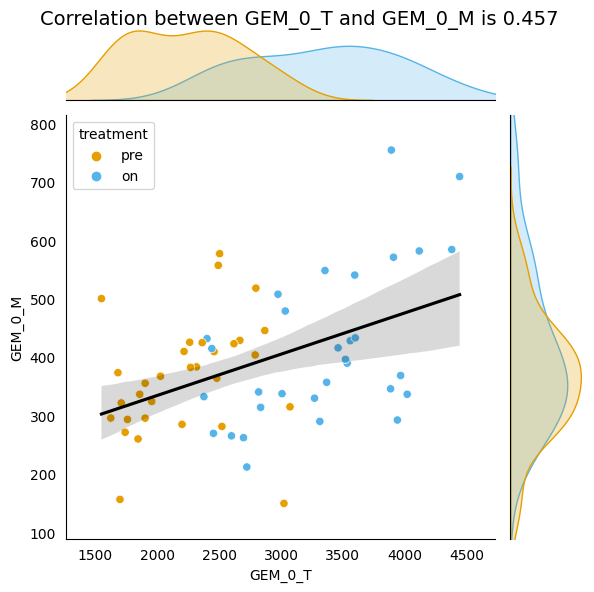

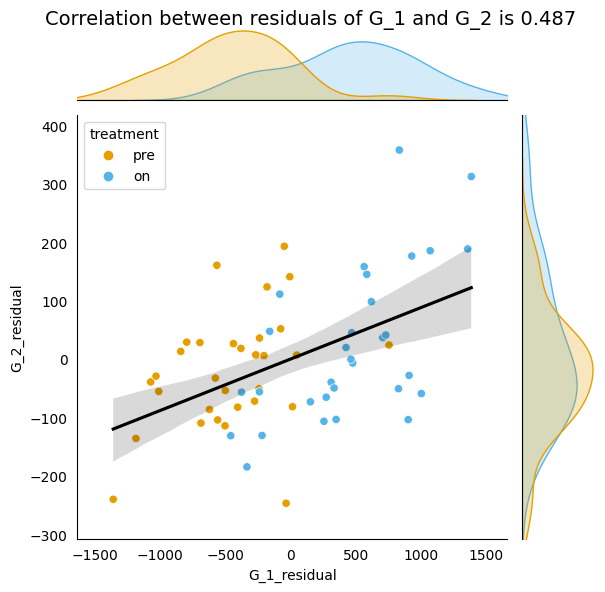

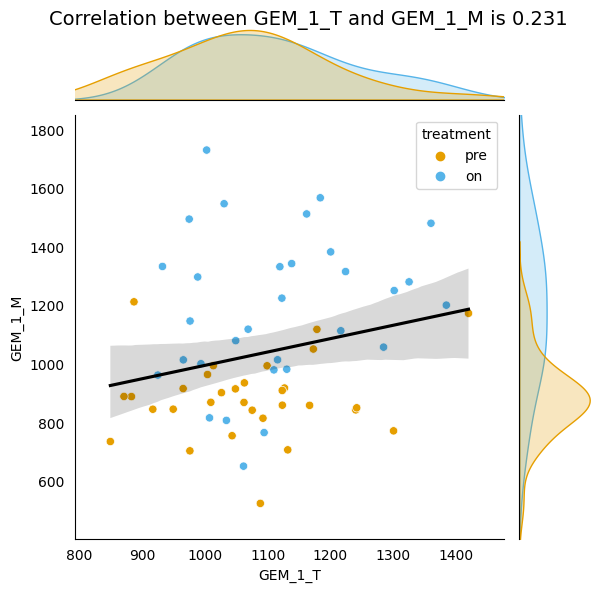

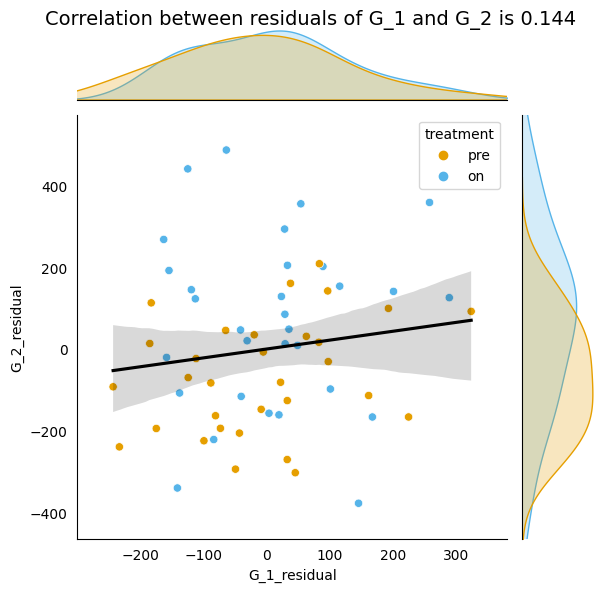

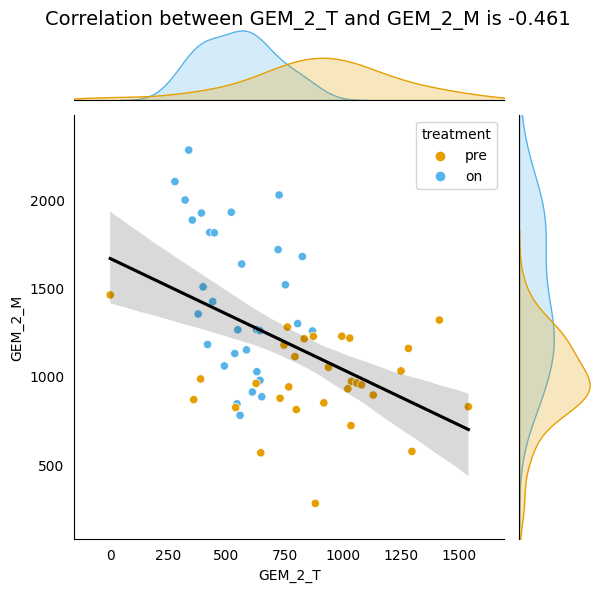

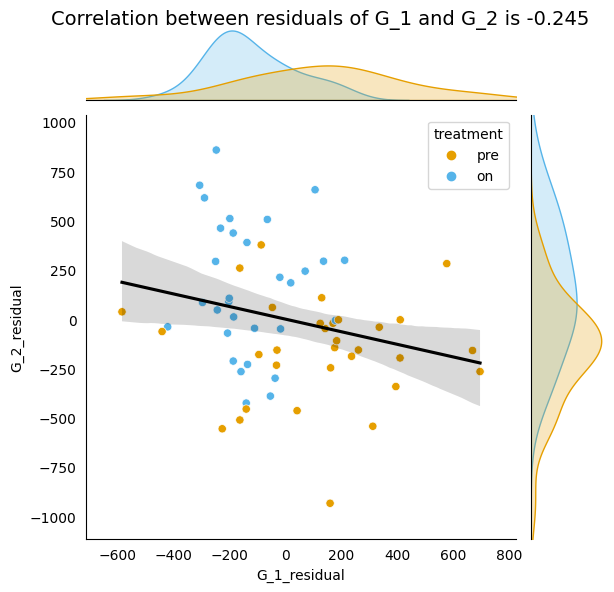

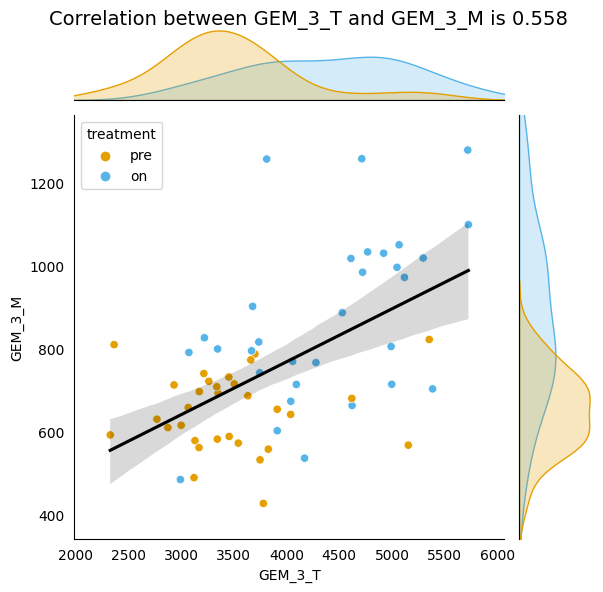

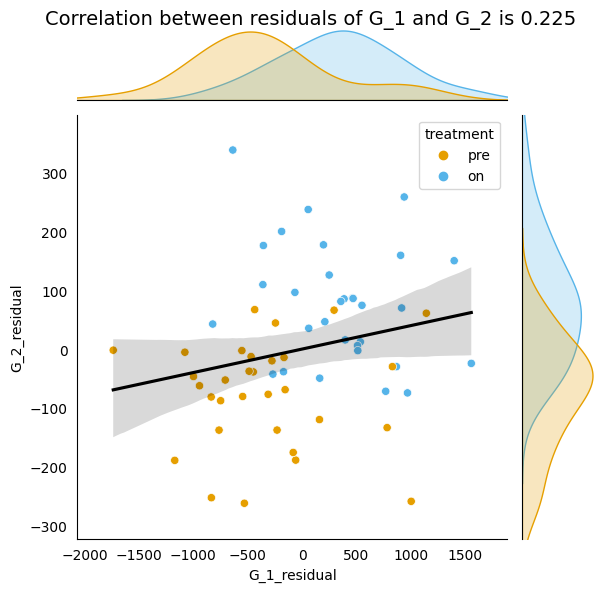

In [56]:
# plot the scatter plot of GEMs use plot_CIT_DEGcorr
for i, row in DEG_pairs.iterrows():
    g1 = 'GEM_' + str(i) + '_T'
    g2 = 'GEM_' + str(i) + '_M'
    L = row['L']
    R = row['R']
    plot_CIT_GEM_DEGcorr(g1, g2, L, R, gene_df, adata_1_pseudo, adata_2_pseudo)


In [ ]:
sc.pl.umap(adata_1, color =['SESN1', 'NFKBIA', 'PMAIP1', 'IL6ST', 'TXNIP', 'PELI1', 'PRDM1', 'CRYBG1', 'TSC22D3', 'TP53INP1'])

# calculate the pvalue of fisherz test

In [26]:
gene_df

,AC004687.1_T,AC004817.3_T,AC004951.1_T,AC006369.1_T,AC007038.2_T,AC015813.1_T,AC016831.5_T,AC021188.1_T,AC023157.3_T,AC025164.1_T,...,GEM_6_T,GEM_6_M,GEM_7_T,GEM_7_M,GEM_8_T,GEM_8_M,GEM_9_T,GEM_9_M,GEM_10_T,GEM_10_M
sample_id,,,,,,,,,,,,,,,,,,,,,
BIOKEY_13_Pre,496.245117,71.430817,0.000000,221.554840,0.000000,0.000000,0.000000,50.375000,66.970314,190.125916,...,2116.363770,1751.891968,654.975464,1219.854492,840.596436,602.306030,2873.021484,1781.311768,4177.022461,945.604431
BIOKEY_13_On,548.931458,73.001106,105.453827,215.637390,50.366783,29.903372,0.000000,249.275970,106.639206,474.283173,...,2769.229980,3186.195312,1457.988159,1336.210571,2012.000977,1081.034546,2946.501709,1844.958618,6067.426270,1746.887939
BIOKEY_10_Pre,563.980347,44.845234,55.078514,81.338425,5.761608,25.467459,9.838195,82.176804,36.126411,164.164597,...,1390.219849,1694.916382,503.294586,683.616516,719.841553,479.275482,2107.589600,851.482605,2115.763184,1082.199707
BIOKEY_10_On,309.215912,189.972443,46.985409,88.311661,13.239152,40.373478,43.434666,111.079369,77.687202,379.605682,...,2147.695312,2180.626709,805.933289,1212.608398,1195.953979,761.712219,2347.500977,1584.123291,3635.119141,1294.540283
BIOKEY_16_Pre,484.466187,89.122238,27.256454,405.647430,4.384324,32.537617,47.155140,20.080681,12.754025,204.002930,...,1486.512207,2112.042969,842.742188,1111.725830,1307.139160,834.176331,2179.301514,1446.561279,3108.436279,1390.966553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BIOKEY_17_On,348.290375,523.852295,0.000000,0.000000,88.987106,0.000000,0.000000,165.759293,252.315216,456.512634,...,3844.134766,3054.263916,545.816772,1432.713257,719.424072,749.555359,2426.692383,1749.822998,6456.602051,1815.263672
BIOKEY_27_Pre,724.247070,0.000000,0.000000,234.127594,0.000000,0.000000,60.133003,0.000000,0.000000,68.258476,...,1738.885498,1428.541992,419.406677,988.403992,582.468506,607.264709,2099.155762,1410.063477,4052.634033,927.412659
BIOKEY_27_On,54.874050,330.519226,53.683594,225.546738,0.000000,58.787476,182.094040,169.446136,245.524399,598.750000,...,3215.373535,2691.144043,1538.118896,1994.231689,2152.541504,1425.546509,3422.994385,2434.781250,7079.975098,1942.751465


In [107]:
grouped_df['GEM_1'] = 'GEM_' + grouped_df.index.astype(str) + '_T'
grouped_df['GEM_2'] = 'GEM_' + grouped_df.index.astype(str) + '_M'

In [108]:
grouped_df

,L,R,g1,g2,Num_genes_g1,Num_genes_g2,Overlapping_g1,Overlapping_g2,GEM_1,GEM_2
0,ANXA1,C5AR1,"[CXCR4, IL7R, SESN1, TXNIP, ZFP36, ZFP36L2]","[ACSL1, ARRDC3, CD163, ELL2, GLUL, RHOB, SESN1...",6,8,"[1, 2, 4, 10]","[1, 4, 5, 10]",GEM_0_T,GEM_0_M
1,ANXA1,CXCR4,"[CITED2, CXCR4, IL7R, SESN1, TXNIP, ZFP36]","[ARRDC2, ARRDC3, ETS2, GPR183, HERPUD1, HMGB2,...",6,11,"[0, 2, 10]","[0, 7]",GEM_1_T,GEM_1_M
2,AREG,ICAM1,"[CBLB, CCNH, CITED2, CXCR4, ERN1, IL7R, TGIF1,...","[GPR183, PFKFB3, TNFAIP3]",8,3,"[0, 1, 10]",[8],GEM_2_T,GEM_2_M
3,CCL5,P2RY13,"[DDIT4, FASLG, NEAT1, PELI1]","[CXorf21, DDIT4, ELL2, IER2, PLIN2]",4,5,[],[10],GEM_3_T,GEM_3_M
4,HMGB2,DAB2,"[CRYBG1, DDIT4, FKBP5, GLUL, IL2RB, NFKBIA, PR...","[ARRDC3, CD163, CPM, CXCR4, ELL2, MAFB, PDK4, ...",16,11,[],"[0, 10]",GEM_4_T,GEM_4_M
5,ICAM1,IL2RG,"[CCNH, CXCR4, TXNIP]","[ARRDC3, CD163, RHOB]",3,3,"[0, 1, 2, 10]","[0, 1, 4, 10]",GEM_5_T,GEM_5_M
6,IL2,IL2RA,"[CD55, GLUL, NFKBIA, ZFP36]","[CPM, GLUL, RGS1, SLC1A3]",4,4,[4],"[0, 4, 10]",GEM_6_T,GEM_6_M
7,ITGA4,CXCR4,"[CEMIP2, CRYBG1, FKBP5, ITK, SERINC5, SPON2, T...","[ETS2, FKBP5, GPR183, HERPUD1, PKP2, RNF144B, ...",7,10,"[4, 8]","[1, 9]",GEM_7_T,GEM_7_M
8,ITGA4,TFRC,"[CEMIP2, CRYBG1, FKBP5, ITK]","[ACSL1, GPR183, MMP19, PFKFB3, RCAN1, SH3BP5, ...",4,7,"[4, 7]",[10],GEM_8_T,GEM_8_M
9,PECAM1,CXCR4,"[SERINC5, SRGN, SSH2]","[FKBP5, GPR183, HERPUD1, PKP2, TSC22D3]",3,5,[4],"[1, 7]",GEM_9_T,GEM_9_M


In [60]:
CIT_GEM_test(grouped_df, adata_1_pseudo, adata_2_pseudo, gene_df, method="kci")

/tmp/ipykernel_1573378/2402461388.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df.loc[index, 'pValue'] = pValue


,L,R,g1,g2,Num_genes_g1,Num_genes_g2,Overlapping_g1,Overlapping_g2,g1vsg2_correlation,g1_residualvsg2_residuals_correlation,GEM_1,GEM_2,pValue
0,ANXA1,C5AR1,"[CXCR4, IL7R, SESN1, TXNIP, ZFP36, ZFP36L2]","[ACSL1, ARRDC3, CD163, ELL2, GLUL, RHOB, SESN1...",6,8,"[1, 2, 4, 10]","[1, 4, 5, 10]",0.565589,0.356832,GEM_0_T,GEM_0_M,0.001277
1,ANXA1,CXCR4,"[CITED2, CXCR4, IL7R, SESN1, TXNIP, ZFP36]","[ARRDC2, ARRDC3, ETS2, GPR183, HERPUD1, HMGB2,...",6,11,"[0, 2, 10]","[0, 7]",0.817018,0.644821,GEM_1_T,GEM_1_M,0.000017
2,AREG,ICAM1,"[CBLB, CCNH, CITED2, CXCR4, ERN1, IL7R, TGIF1,...","[GPR183, PFKFB3, TNFAIP3]",8,3,"[0, 1, 10]",[8],0.596442,0.412105,GEM_2_T,GEM_2_M,0.001680
4,HMGB2,DAB2,"[CRYBG1, DDIT4, FKBP5, GLUL, IL2RB, NFKBIA, PR...","[ARRDC3, CD163, CPM, CXCR4, ELL2, MAFB, PDK4, ...",16,11,[],"[0, 10]",0.641912,0.457068,GEM_4_T,GEM_4_M,0.000277
5,ICAM1,IL2RG,"[CCNH, CXCR4, TXNIP]","[ARRDC3, CD163, RHOB]",3,3,"[0, 1, 2, 10]","[0, 1, 4, 10]",0.497741,0.343651,GEM_5_T,GEM_5_M,0.044510
6,IL2,IL2RA,"[CD55, GLUL, NFKBIA, ZFP36]","[CPM, GLUL, RGS1, SLC1A3]",4,4,[4],"[0, 4, 10]",0.637294,0.534674,GEM_6_T,GEM_6_M,0.000007
7,ITGA4,CXCR4,"[CEMIP2, CRYBG1, FKBP5, ITK, SERINC5, SPON2, T...","[ETS2, FKBP5, GPR183, HERPUD1, PKP2, RNF144B, ...",7,10,"[4, 8]","[1, 9]",0.730367,0.604754,GEM_7_T,GEM_7_M,0.000047
8,ITGA4,TFRC,"[CEMIP2, CRYBG1, FKBP5, ITK]","[ACSL1, GPR183, MMP19, PFKFB3, RCAN1, SH3BP5, ...",4,7,"[4, 7]",[10],0.632348,0.458272,GEM_8_T,GEM_8_M,0.012416
9,PECAM1,CXCR4,"[SERINC5, SRGN, SSH2]","[FKBP5, GPR183, HERPUD1, PKP2, TSC22D3]",3,5,[4],"[1, 7]",0.737597,0.635059,GEM_9_T,GEM_9_M,0.000003
10,RPS19,C5AR1,"[CXCR4, IL7R, TSC22D3, TXNIP, ZFP36, ZFP36L2]","[ACSL1, ARRDC3, CD163, CPM, ELL2, GLUL, MAFB, ...",6,13,"[0, 1, 2, 4]","[0, 4]",0.575780,0.315276,GEM_10_T,GEM_10_M,0.141289


In [61]:
# save the grouped_df to excel
grouped_df.to_excel('/home/qiuaodon/Desktop/project_data_new/CIT_results_PD1vsM_grouped_0920.xlsx')

In [59]:
def CIT_GEM_test(grouped_df, adata_1_pseudo, adata_2_pseudo, gene_df, method="kci"):
    for index, row in grouped_df.iterrows():
        g1 = row['GEM_1']
        g2 = row['GEM_2']
        L = row['L']
        R = row['R']
        if L in adata_1_pseudo.var_names and R in adata_2_pseudo.var_names:
                    # Get the L_T and R_B from pseudo_T and pseudo_M
                    L_T = adata_1_pseudo[:, L].X
                    L_T = pd.DataFrame(L_T, columns=[L], index=adata_1_pseudo.obs['sample_id']).dropna()
                    R_M = adata_2_pseudo[:, R].X
                    R_M = pd.DataFrame(R_M, columns=[R], index=adata_2_pseudo.obs['sample_id']).dropna()
                    
                    # Calculate L*R
                    L_T.columns = [R + '_vs_' + L]
                    R_M.columns = L_T.columns
                    L_R = L_T.multiply(R_M, axis=0).iloc[:, 0]

                    # Make a DataFrame g1, g2 and L*R
                    if g1 not in gene_df.columns or g2 not in gene_df.columns:
                        continue
                    
                    g1_T = gene_df[g1]
                    g2_M = gene_df[g2]
                    df = pd.DataFrame({g1: g1_T, g2: g2_M, 'L*R': L_R}).dropna()

                    # Convert df to numpy array
                    df_numpy = df.to_numpy()

                    # Perform the chosen independence test
                    if method == "kci":
                        cit_obj = CIT(df_numpy, "kci")
                    elif method == "fisherz":
                        cit_obj = CIT(df_numpy, "fisherz")
                    else:
                        raise ValueError("Unsupported method. Use 'kci' or 'fisherz'.")
                    
                    pValue = cit_obj(0, 1, [2])
                    
                    grouped_df.loc[index, 'pValue'] = pValue
    return grouped_df


# plot individual DEG pair UMAP

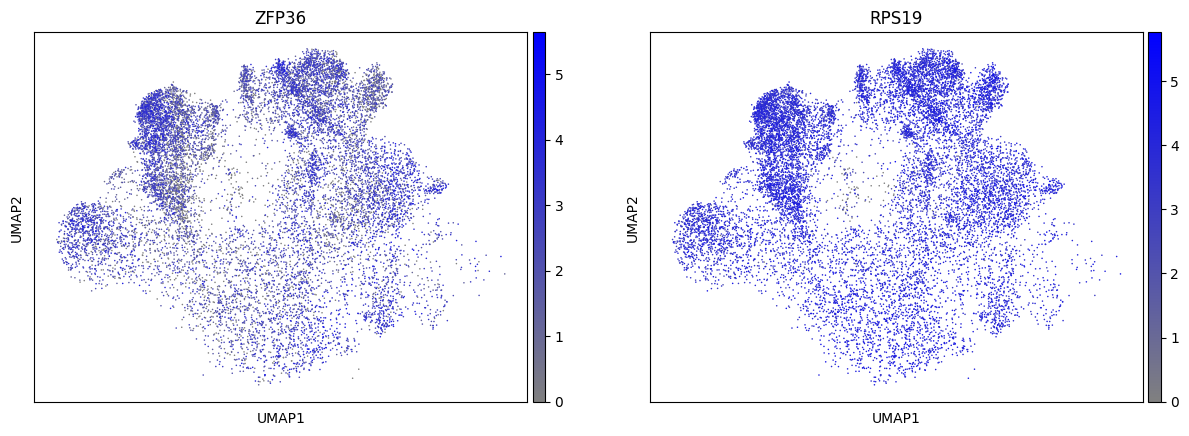

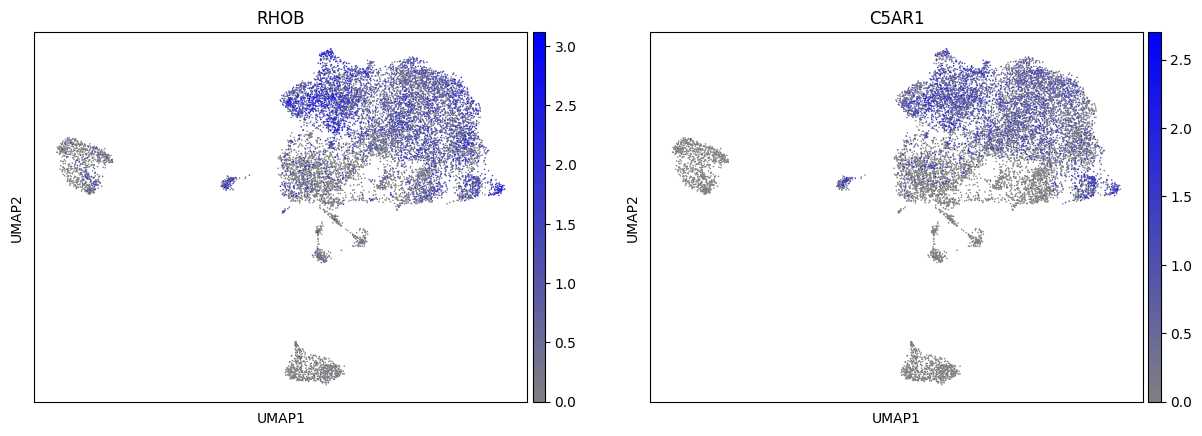

In [149]:
sc.pl.umap(adata_1, color = ['ZFP36', 'RPS19'], cmap = cmap, size=5)
sc.pl.umap(adata_2, color = ['RHOB', 'C5AR1'], cmap = cmap, size=5)

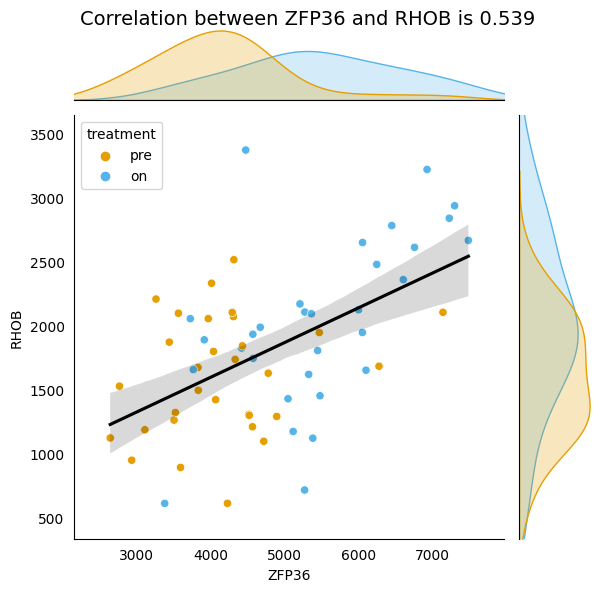

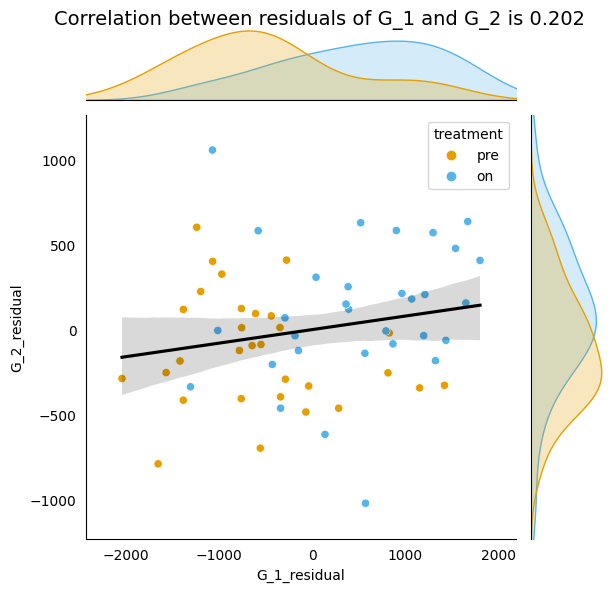

In [100]:
plot_CIT_DEGcorr('ZFP36', 'RHOB', 'RPS19', 'C5AR1', gene_df, adata_1_pseudo, adata_2_pseudo)

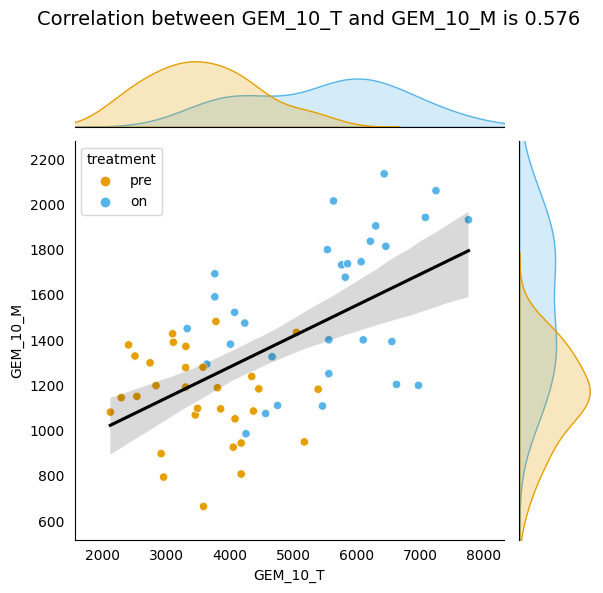

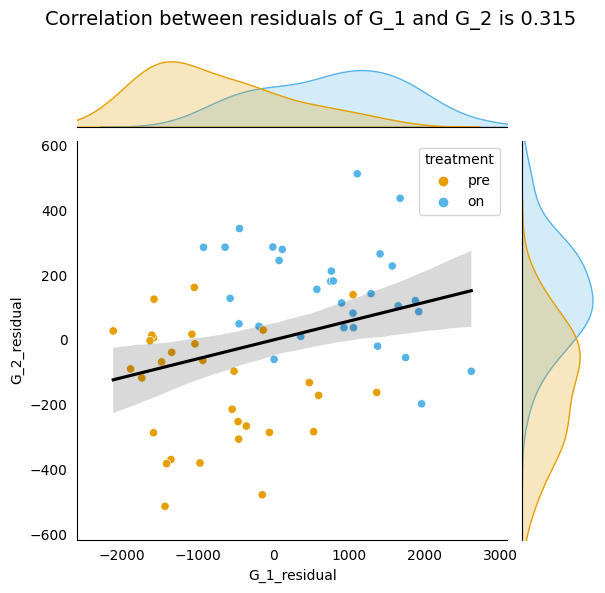

In [111]:
# plot the scatter plot of GEMs use plot_CIT_DEGcorr

g1 = 'GEM_10_T'
g2 = 'GEM_10_M'
L = 'RPS19'
R = 'C5AR1'
plot_CIT_1DEGcorr(g1, g2, L, R, gene_df, adata_1_pseudo, adata_2_pseudo)
### if the corr is different, it is becuase the value from gene_df and adata_1_pseudo and adata_2_pseudo are different

In [102]:
def plot_CIT_1DEGcorr(g1, g2, L, R, DEG_exp, pseudo_1, pseudo_2):
    # Define a custom palette
    palette = {'pre': "#E69F00", 'on': "#56B4E9"}
    #replace the treatment column 0 pre and 1 on
    DEG_exp['treatment'] = DEG_exp['treatment'].replace({0: 'pre', 1: 'on'})
    # Set font sizes
    title_fontsize = 14
    axis_fontsize = 14
    legend_fontsize = 12

    def adjust_plot_limits(ax, x_data, y_data):
        x_min, x_max = x_data.min(), x_data.max()
        y_min, y_max = y_data.min(), y_data.max()
        x_padding = (x_max - x_min) * 0.1
        y_padding = (y_max - y_min) * 0.1
        ax.set_xlim(x_min - x_padding, x_max + x_padding)
        ax.set_ylim(y_min - y_padding, y_max + y_padding)

    # Plot the jointplot between DEG of g1 and g2
    g1_exp = adata_1_pseudo.obs[g1]
    g2_exp = adata_2_pseudo.obs[g2]
    df1 = pd.DataFrame({g1: g1_exp, g2: g2_exp, 'treatment': DEG_exp['treatment']})
    df1 = df1.dropna()
    g = sns.jointplot(x=g1, y=g2, data=df1, hue='treatment', palette=palette, kind='scatter', marginal_kws=dict(fill=True))
    sns.regplot(x=g1, y=g2, data=df1, scatter=False, ax=g.ax_joint, color='black')
    adjust_plot_limits(g.ax_joint, df1[g1], df1[g2])
    
    g.ax_joint.tick_params(left=False, bottom=False)
    g.ax_marg_x.tick_params(bottom=False)
    g.ax_marg_y.tick_params(left=False)
    cor = pearsonr(df1[g1], df1[g2])[0]
    plt.suptitle(f'Correlation between {g1} and {g2} is {cor:.3f}', fontsize=title_fontsize)
    plt.subplots_adjust(top=0.9)
    plt.show()

     # Plot the jointplot between DEG of g1 and g2 residue
    L_values = pseudo_1[:, L].X.toarray().flatten()
    R_values = pseudo_2[:, R].X.toarray().flatten()
    L_R = L_values * R_values
    X = sm.add_constant(L_R)

    # Fit OLS model for g2
    model_g2 = sm.OLS(g2_exp, X).fit()
    residuals_g2 = model_g2.resid

    # Fit OLS model for g1
    model_g1 = sm.OLS(g1_exp, X).fit()
    residuals_g1 = model_g1.resid

    #   Create DataFrame for residuals
    df_res = pd.DataFrame({
        'G_1_residual': residuals_g1,
        'G_2_residual': residuals_g2,
        'treatment': DEG_exp['treatment']
    })

    # Plot the residuals
    g = sns.jointplot(x='G_1_residual', y='G_2_residual', data=df_res, hue='treatment', palette=palette, kind='scatter', marginal_kws=dict(fill=True))
    sns.regplot(x='G_1_residual', y='G_2_residual', data=df_res, scatter=False, ax=g.ax_joint, color='black')

    # Adjust plot limits if needed
    adjust_plot_limits(g.ax_joint, df_res['G_1_residual'], df_res['G_2_residual'])

    # Customize plot appearance
    g.ax_joint.tick_params(left=False, bottom=False)
    g.ax_marg_x.tick_params(bottom=False)
    g.ax_marg_y.tick_params(left=False)

    # Calculate and display correlation
    corr_res = pearsonr(df_res['G_1_residual'], df_res['G_2_residual'])[0]
    plt.suptitle(f'Correlation between residuals of G_1 and G_2 is {corr_res:.3f}', fontsize=title_fontsize)
    plt.subplots_adjust(top=0.9)
    plt.show()
